# Final Project 

- Dataset: https://www.kaggle.com/PromptCloudHQ/imdb-data
- Notes: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
---

## About Dataset


### Movie Dataset 

- 1,000 most popular movies on IMDB in 10 years from 2006-2016. 
- There are 12 Feature: 
    - Title, Genre, Description, Director, Actors, Year, Runtime, Rating, Votes, Revenue, Metascrore
- I am going to train a model that uses the description written about the movie and predict movie genres
    



# Goal: Predicting the Genre of the Movie Using its Description

# Importing the packeges

In [42]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

from wordcloud import WordCloud, STOPWORDS

### Copying stopwords dictionary E.g. the, a, but, etc.

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesmccrory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Exploration

### Load Data

In [44]:
# read the file
df = pd.read_csv("movies.csv")

In [84]:
df[(df['Rank']) == 33]

Rank              Title                    Genre  \
32    33  X-Men: Apocalypse  Action,Adventure,Sci-Fi   

                                          Description      Director  \
32  re-emergence world's first mutant, world-destr...  Bryan Singer   

                                               Actors  Year  \
32  James McAvoy, Michael Fassbender, Jennifer Law...  2016   

    Runtime (Minutes)  Rating   Votes  Revenue (Millions)  Metascore  
32                144     7.1  275510              155.33       52.0

In [46]:
# looking at the length of the 1st description to get a picture how long a descriotion can be
word_count = (df["Description"].values[0]).split(" ")
print("list of words from a description: {}\n Word count:{}".format(word_count, len(word_count)))


list of words from a description: ['A', 'group', 'of', 'intergalactic', 'criminals', 'are', 'forced', 'to', 'work', 'together', 'to', 'stop', 'a', 'fanatical', 'warrior', 'from', 'taking', 'control', 'of', 'the', 'universe.']
 Word count:21


### Function removes stopwords to remove noise 

In [47]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# nltk.download('stopwords')

# function to remove stopwords
def remove_stopwords(text):
    """Removes stopwords and lowercase the words"""
    no_stopword_text = [word for word in text.split() if not word in stop_words]
    return ' '.join(no_stopword_text)

df['Description'] = df['Description'].apply(lambda x: remove_stopwords(x.lower()))

In [48]:
df.head()

Rank                    Title                     Genre  \
0     1  Guardians of the Galaxy   Action,Adventure,Sci-Fi   
1     2               Prometheus  Adventure,Mystery,Sci-Fi   
2     3                    Split           Horror,Thriller   
3     4                     Sing   Animation,Comedy,Family   
4     5            Suicide Squad  Action,Adventure,Fantasy   

                                         Description              Director  \
0  group intergalactic criminals forced work toge...            James Gunn   
1  following clues origin mankind, team finds str...          Ridley Scott   
2  three girls kidnapped man diagnosed 23 distinc...    M. Night Shyamalan   
3  city humanoid animals, hustling theater impres...  Christophe Lourdelet   
4  secret government agency recruits dangerous in...            David Ayer   

                                              Actors  Year  Runtime (Minutes)  \
0  Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...  2014                121   
1  Noomi Rapace, Logan Marshall-Green, Michael Fa...  2012                124   
2  James McAvoy, Anya Taylor-Joy, Haley Lu Richar...  2016                117   
3  Matthew McConaughey,Reese Witherspoon, Seth Ma...  2016                108   
4  Will Smith, Jared Leto, Margot Robbie, Viola D...  2016                123   

   Rating   Votes  Revenue (Millions)  Metascore  
0     8.1  757074              333.13       76.0  
1     7.0  485820              126.46       65.0  
2     7.3  157606              138.12       62.0  
3     7.2   60545              270.32       59.0  
4     6.2  393727              325.02       40.0

# Steps:
1. Spliting input and target (input is descriptoin, movie genre would be the output)
2. One-hot encoding 
3. multi-label classification
    - Since movies are not one-dimensional. One movie can span several genres. Now THAT is a challenge I love to embrace as a data scientist. I extracted a bunch of movie plot summaries and got down to work using this concept of multi-label classification. And the results, even using a simple model, are truly impressive.

### Creating a dataset that will be suited to fit our model
- so we can have easier dataset to work with to do train test split part.
- The we have input and output. Independed variable "Description" column and our target, depended variable will  be movie genres we want to predict.

In [49]:
# copying the Description and Genre of a movie
dataset = pd.DataFrame(df[["Description", "Genre"]])

### Overwriting Old Genre Data with New Genres Objects

In [50]:
genres = list()

for item in dataset["Genre"]:
    genres.append(item.split(","))

dataset["Genre"] = genres

### Now we have a desired dataset 

In [51]:
dataset.head(10)

Description  \
0  group intergalactic criminals forced work toge...   
1  following clues origin mankind, team finds str...   
2  three girls kidnapped man diagnosed 23 distinc...   
3  city humanoid animals, hustling theater impres...   
4  secret government agency recruits dangerous in...   
5  european mercenaries searching black powder be...   
6   jazz pianist falls aspiring actress los angeles.   
7  has-been actor best known playing title charac...   
8  true-life drama, centering british explorer co...   
9  spacecraft traveling distant colony planet tra...   

                            Genre  
0     [Action, Adventure, Sci-Fi]  
1    [Adventure, Mystery, Sci-Fi]  
2              [Horror, Thriller]  
3     [Animation, Comedy, Family]  
4    [Action, Adventure, Fantasy]  
5    [Action, Adventure, Fantasy]  
6          [Comedy, Drama, Music]  
7                        [Comedy]  
8  [Action, Adventure, Biography]  
9     [Adventure, Drama, Romance]

In [52]:
# check how many genres we have 

In [57]:
all_genres = set()
for array in dataset['Genre']:
    for genre in array:
        if genre not in all_genres:
            all_genres.add(genre)
            
all_genres = list(all_genres)

print(all_genres)

['Comedy', 'Sport', 'Mystery', 'Musical', 'Western', 'Animation', 'Music', 'Adventure', 'Sci-Fi', 'Horror', 'History', 'Family', 'Drama', 'Romance', 'Fantasy', 'Biography', 'Action', 'Crime', 'Thriller', 'War']


In [58]:
len(all_genres)

20

- There are 20 unique genre tags in our dataset. But we dont how often each genre occured.
We will use FreqDist( ) from the nltk library to create a dictionary of genres 
and their occurrence count across the dataset:


In [59]:
genre_list = dataset["Genre"]
genre_list.tolist()
# flatting the list 
genre_list = [item for sublist in genre_list for item in sublist]
print(len(genre_list))

2555


## Now we have histogram for genres. Let's visualize them.

In [60]:

all_genres = nltk.FreqDist(genre_list) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})


all_genres_df


Genre  Count
0      Action    303
1   Adventure    259
2      Sci-Fi    120
3     Mystery    106
4      Horror    119
5    Thriller    195
6   Animation     49
7      Comedy    279
8      Family     51
9     Fantasy    101
10      Drama    513
11      Music     16
12  Biography     81
13    Romance    141
14    History     29
15      Crime    150
16    Western      7
17        War     13
18    Musical      5
19      Sport     18

## Visualize the genres

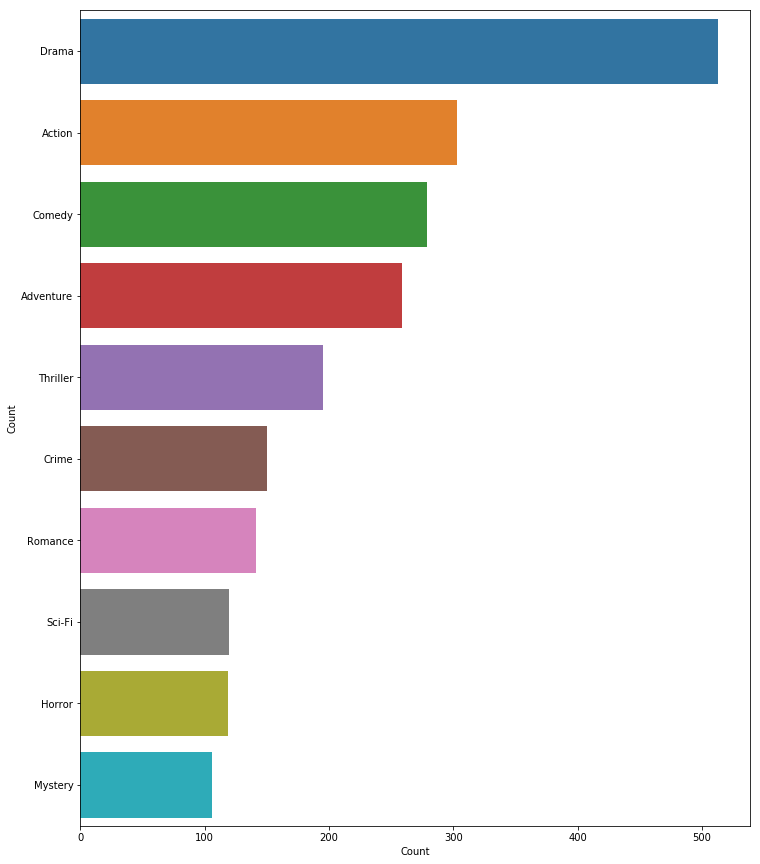

In [61]:
g = all_genres_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()


# Initialize multilabel model 

In [64]:

data_mlb = MultiLabelBinarizer()

data_mlb.fit(dataset['Genre'])


# transform target variable
target = data_mlb.transform(dataset['Genre'])

list(data_mlb.classes_)

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [65]:
target[:10]

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

# Train Test Split

In [66]:
# training and validation set
X_train, X_test, y_train, y_test = train_test_split(dataset["Description"], 
                                                    target, 
                                                    train_size=0.75, 
                                                    test_size=0.25)

# TF-IDF

In [67]:
tfidf_proc = TfidfVectorizer(max_df=0.8, max_features=10000)

X_train_TFIDF = tfidf_proc.fit_transform(X_train)
X_test_TFIDF = tfidf_proc.transform(X_test)

# One-vs-the-rest (OvR) multiclass/multilabel strategy

- Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its **interpretability**. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the **most commonly used strategy** for multiclass classification and is a fair default choice

In [68]:
logreg_model = LogisticRegression() # we're still doing classification! 
clf = OneVsRestClassifier(logreg_model)

In [69]:
# fit model on train data
clf.fit(X_train_TFIDF, y_train)

/Users/jamesmccrory/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [70]:
# make predictions for validation set
y_pred = clf.predict(X_test_TFIDF)

In [71]:
y_pred[:20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0,

In [72]:
naive_sample = 22
y_pred[naive_sample]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Transform the multi-lable model to word(movie genre) 

In [73]:
data_mlb.inverse_transform(y_pred)[naive_sample]

()

## Evaluate the first naive model f1_score

In [74]:
# evaluate performance
f1_score(y_test, y_pred, average="micro")

0.2487309644670051

# Optimizing the model decrease the threshold using .predict_proba()

In [75]:
# predict probabilities
y_pred_proba = clf.predict_proba(X_test_TFIDF)
y_pred_proba

array([[0.2660543 , 0.31263974, 0.06581879, ..., 0.14092912, 0.01611131,
        0.01354991],
       [0.30442397, 0.23871682, 0.05965692, ..., 0.15314805, 0.01608064,
        0.01638912],
       [0.26186325, 0.17376124, 0.04361655, ..., 0.19672408, 0.01763629,
        0.01400509],
       ...,
       [0.33248259, 0.24109426, 0.05074351, ..., 0.18956761, 0.01657361,
        0.01437711],
       [0.44863089, 0.25300518, 0.04595138, ..., 0.19178614, 0.01573283,
        0.01513398],
       [0.40640275, 0.27597008, 0.05341017, ..., 0.16474028, 0.01854605,
        0.01451753]])

In [76]:
threshold = 0.27 # threshold value
y_pred_corrected = (y_pred_proba >= threshold).astype(int)

In [77]:
# evaluate performance
f1_score(y_test, y_pred_corrected, average="micro")
# print("F1 score: ",f1_score )

0.48534201954397393

In [78]:
# now checking the model with new threshold

In [79]:
sample = 34
y_pred_corrected[sample]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
data_mlb.inverse_transform(y_pred_corrected)[sample]

('Comedy', 'Drama')

In [35]:
manual_check = 99
print(y_test[manual_check])
print(y_pred_corrected[manual_check])

[1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


# All Predicted Labels

In [36]:
# check the results
iterations = len(y_pred_corrected)
y_pred_transform_to_genre = []
for i in range(iterations):
    y_pred_transform_to_genre.append(data_mlb.inverse_transform(y_pred_corrected)[i])
y_pred_transform_to_genre

[('Comedy', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Drama', 'Thriller'),
 ('Action', 'Drama'),
 ('Action', 'Adventure', 'Drama'),
 ('Action', 'Adventure', 'Drama'),
 ('Comedy', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Adventure', 'Comedy', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Action', 'Adventure', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Comedy', 'Drama'),
 ('Drama',),
 ('Drama',),
 ('Action', 'Drama'),
 ('Action', 'Drama'),
 ('Adventure', 'Comedy', 'Drama'),
 ('Action', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Action', 'Comedy', 'Crime', 'Drama'),
 ('Action', 'Comedy', 'Drama'),
 ('Action', 'Adventure', 'Comedy', 'Drama'),
 ('Action', 'Drama'),
 ('Action', 'Adventure', 'Drama'),
 ('Action', 'Adventure', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Drama'),
 ('Comedy', 'Drama'),
 ('Comedy', 'Drama'),
 ('Action', 'Adventure', 'Comedy', 'Drama')

In [37]:
# data_mlb

## Create Word Cloud

In [38]:
def create_wordcloud(dataset):
    text = " ".join(desc for desc in dataset)
    wordcloud = WordCloud(width=1500, height=800, max_font_size=200, background_color = 'White').generate(text)
    plt.figure(figsize=(20,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

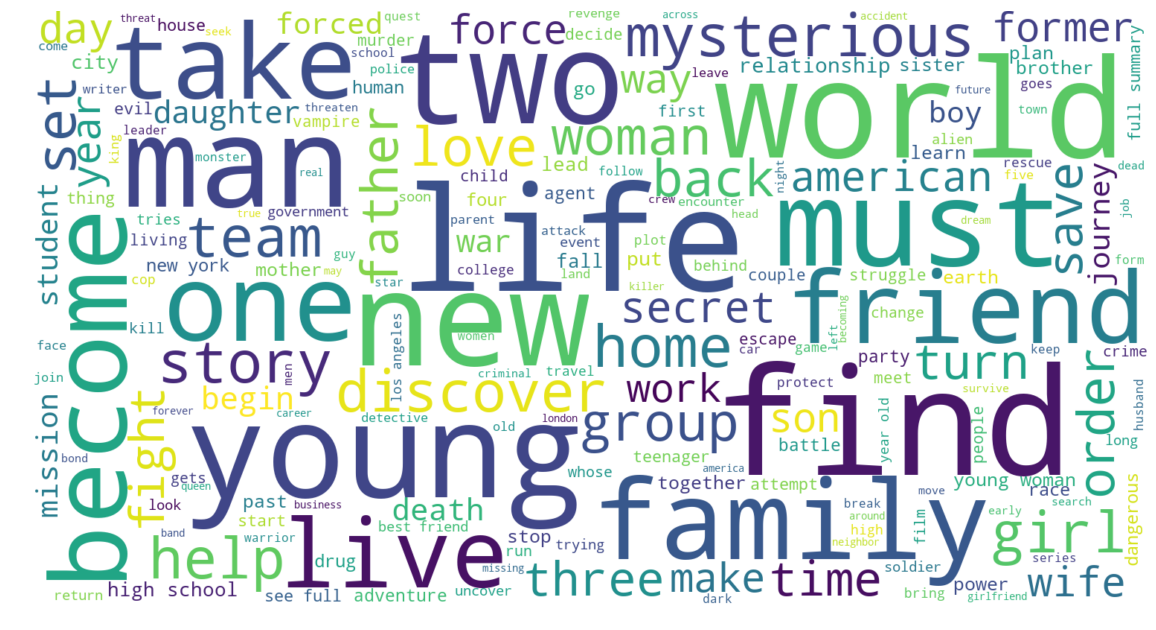

In [39]:
create_wordcloud(dataset["Description"])

# Next Steps:
1. Test multiple different classification models!
2. Use `GridSearchCV` or Custom Hyperparameter Tuning to Boost Performance!
3. More EDA and Visualization!

In [ ]:
# # Super cool code! 

# Another way to perform **multilabel binarization** without the package!

In [ ]:
# label_binarization = dataset.Genre.str.split(',', expand=True).stack()
# mlb_data = pd.get_dummies(label_binarization, prefix='is').groupby(level=0).sum()
# dataset = dataset.join(mlb_data)
# dataset.drop(columns=["Genre"], inplace=True)

#### put cell from  `all_genres = list(data_mlb.classes_)` `Visualize the genres`